In [1]:
%load_ext rpy2.ipython

In [2]:
from platform import python_version
print 'The python version used is: ' + python_version()

The python version used is: 2.7.5


In [3]:
# this script uses python2(hddm) instead of python3(hddm) because..
# python3 is very slow in the mcmc sampling process..
# python3 produces an error like "Step-out procedure failed" when using multiprocessing for speed up..
# overall this script takes atleast a few days on a machine with atleast 28 cores..

In [4]:
import time
import timeit

In [5]:
print('Script started at: ' +  time.strftime('%X %x %Z'))

Script started at: 07:57:12 04/04/21 BST


In [6]:
import os, sys, pickle, time
import pandas as pd
import textwrap
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pickle
%pylab inline
import seaborn as sns
from rpy2.robjects import r
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
paper_rc = {'lines.linewidth': 0.4, 'lines.markersize': 1}                  
sns.set_context("paper", rc = paper_rc)

Populating the interactive namespace from numpy and matplotlib


In [7]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [8]:
label_fontsize = 16
title_fontsize = 16

In [9]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [10]:
sns.set(font_scale=1.25, style="whitegrid")

In [11]:
base_dir = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/'
beh_files = 'decAlertnessDecisionmaking_JNeuroscience2021/beh_data/csv_files/'
output_dir = 'decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

In [12]:
import multiprocessing
from multiprocessing import Pool

In [13]:
multiprocessing.cpu_count()

28

In [14]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [15]:
from pymc import MCMC

In [16]:
import pymc3 as pm

In [17]:
import hddm
print(hddm.__version__)

0.7.1


/home/srj34/jupyter-hddm-env/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [18]:
import pymc
pymc.__version__

'2.3.6'

In [19]:
def interpolate_trace(x, trace, range=(-1,1), bins=100):
    """Interpolate distribution (from samples) at position x.
    :Arguments:
        x <float>: position at which to evalute posterior.
        trace <np.ndarray>: Trace containing samples from posterior.
    :Optional:
        range <tuple=(-1,1): Bounds of histogram (should be fairly
            close around region of interest).
        bins <int=100>: Bins of histogram (should depend on trace length).
    :Returns:
        float: Posterior density at x.
    """

    import scipy.interpolate

    x_histo = np.linspace(range[0], range[1], bins)
    histo = np.histogram(trace, bins=bins, range=range, density=True)[0]
    interp = scipy.interpolate.InterpolatedUnivariateSpline(x_histo, histo)(x)

    return interp

In [20]:
def effectsize(group1_node, group2_node):
    with pm.Model() as model:
        group1 = group1_node.trace()
        group2 = group2_node.trace()
        group1_mean = group1.mean()
        group2_mean = group2.mean()
        group1_std = group1.std() * 2
        group2_std = group2.std() * 2
        diff_of_means = group1_mean - group2_mean
        diff_of_stds = group1_std - group2_std
        effect_size = diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    return effect_size

In [21]:
def savePatch(self, fname):
    with open(fname, 'wb') as f:
        pickle.dump(self, f)
hddm.HDDM.savePatch = savePatch

In [22]:
#read the csv file first (created by process_create_StimCodeRTs)
csvfilepath = base_dir + beh_files + "responsecoding_stimcode_state.csv"
data_overall = hddm.load_csv(csvfilepath)

#now remove some of the unwanted columns to keep it clean..
del data_overall['angle']
del data_overall['accuracy']
del data_overall['stimcode']
del data_overall['difficulty']

#now reorder them..
data_overall = data_overall[['subj_idx', 'ovtrlnums', 'stim', 'rt', 'response', 'state']]

In [23]:
data_overall.head()

,subj_idx,ovtrlnums,stim,rt,response,state
0,2.0,1.0,Right,0.904771,0,Alert
1,2.0,2.0,Left,1.032423,1,Alert
2,2.0,3.0,Left,1.145844,1,Alert
3,2.0,4.0,Left,1.099559,1,Alert
4,2.0,5.0,Left,1.228592,1,Alert


In [24]:
data_overall.tail()

,subj_idx,ovtrlnums,stim,rt,response,state
21143,46.0,853.0,Left,4.871518,1,Drowsy
21144,46.0,855.0,Left,1.711324,1,Drowsy
21145,46.0,857.0,Right,1.241904,0,Drowsy
21146,46.0,863.0,Left,0.927672,1,Relaxed
21147,46.0,864.0,Right,0.547870,0,Relaxed


In [25]:
statepurgegrp = ['Relaxed'] #remove this state from the data..
behdata = data_overall[~data_overall['state'].isin(statepurgegrp)]

In [26]:
print('maximum rt: ', str(np.max(behdata.rt)))
print('minimum rt: ', str(np.min(behdata.rt)))

('maximum rt: ', '4.908807')
('minimum rt: ', '0.024684')


In [27]:
behdata.state.unique()

array(['Alert', 'Drowsy'], dtype=object)

In [28]:
behdata.subj_idx.unique()

array([  2.,   4.,   5.,   6.,   7.,   9.,  10.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  41.,  42.,  43.,  44.,  45.,  46.])

In [29]:
print ('RT mean - Alert:' + str(1000*np.mean(behdata.rt[behdata.state == 'Alert'])))
print ('RT mean - Drowsy:' + str(1000*np.mean(behdata.rt[behdata.state == 'Drowsy'])))

RT mean - Alert:695.152978332
RT mean - Drowsy:1181.05468657


In [30]:
model_basedir = base_dir + 'decAlertnessDecisionmaking_JNeuroscience2021/beh_data/hddm_models'

In [31]:
fig_dir = base_dir + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Figures/'

In [32]:
num_samples = 1500 #10

In [33]:
model_name = 'model_1'          
v_pars = {'state','stim'}
z_pars = {'stim'}
a_pars = {'state'}
t_pars = {'state'}
tempval = 1
model_dir = model_basedir +'/combined_models_py27/' + model_name
model_fullname = os.path.join(model_dir, model_name+ '_db')
if not os.path.exists(model_fullname):

    m = hddm.HDDMStimCoding(behdata, p_outlier = 0.05, stim_col='stim', split_param='v',
                            drift_criterion=False, bias=True,
                            depends_on={'v':v_pars, 'z':z_pars, 'a':a_pars, 't': t_pars})   
    m.find_starting_values()    
    samples = num_samples
    num_burn = num_samples/10
    tracefilename = 'traces_' + str(tempval) + '.db' #'traces.db'
    if not os.path.exists(model_dir):
           os.makedirs(model_dir)
    m.sample(samples, burn=num_burn, thin=3, dbname=os.path.join(model_dir, tracefilename), 
             db='pickle')
    m.savePatch(model_fullname)
else:
    print('\nmodelfile: ' + model_fullname + ' \n already exists..')
    if os.path.isfile(model_fullname):
        with open(model_fullname, 'rb') as f:
                m_load = pickle.load(f)
    m = m_load 
        

m_stats = m.gen_stats()
print('\nWinning model is ' + model_name )
print('model parms','v:', ', '.join(v_pars), '--',
                    'z:', ', '.join(z_pars), '--',
                    'a:', ', '.join(a_pars), '--',
                    't:', ', '.join(t_pars))
print(model_name, 'DIC {0:.2f}'.format(m.dic))


modelfile: /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/beh_data/hddm_models/combined_models_py27/model_1/model_1_db 
 already exists..

Winning model is model_1
('model parms', 'v:', 'state, stim', '--', 'z:', 'stim', '--', 'a:', 'state', '--', 't:', 'state')
('model_1', 'DIC 20136.95')


('P_t(t_Alert > t_Drowsy) = ', 30.444444444444446)
('Effect size = ', -0.31896893122599318)


Text(0.5,0.98,'non-decision time')

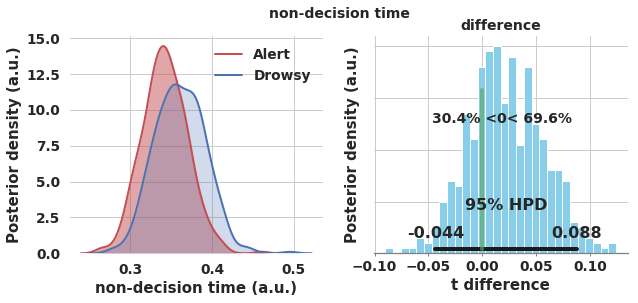

In [34]:
t_Alert, t_Drowsy = m.nodes_db.node[['t(Alert)', 't(Drowsy)']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axplot_1 = sns.kdeplot(t_Alert.trace(), shade = True, vertical=False, label = "Alert",color = "r",linewidth = 2, ax=ax[0])   
axplot_1.collections[0].set_alpha(0.5)
axplot_2 = sns.kdeplot(t_Drowsy.trace(), shade = True, vertical=False, label = "Drowsy", color = "b",linewidth = 2,ax=ax[0])
axplot_2.collections[0].set_alpha(0.5)
axplot_3 = ax[0].legend(['Alert','Drowsy'],loc='upper right',framealpha = 0)
ax[0].set(xlabel='non-decision time (a.u.)', ylabel='Posterior density (a.u.)')
effect_size = effectsize(t_Alert, t_Drowsy)
trace = t_Drowsy.trace() - t_Alert.trace() 
# axplot = pm.plot_posterior(trace, ref_val=0, point_estimate = None, hdi_prob = 0.95, kind='hist',
#                            color='#87ceeb',  ax=ax[1])
axplot = pm.plot_posterior(trace, varnames=['diff_of_means'],
                  ref_val=0, alpha_level=0.05, kde_plot=False, point_estimate = False,
                  color='#87ceeb',  ax=ax[1])
axplot.set_title("difference", fontsize = 14, fontweight = 'bold')
ax[1].set(xlabel='t difference', ylabel='Posterior density (a.u.)')

axplot_1.set_frame_on(False)
axplot_1.grid(True)
axplot_2.set_frame_on(False)
axplot_2.grid(True)

print('P_t(t_Alert > t_Drowsy) = ', 100*(t_Alert.trace() > t_Drowsy.trace()).mean())
print('Effect size = ', effect_size)
plt.suptitle("non-decision time", fontsize = 14, weight = 'bold')

('P_a(a_Alert > a_Drowsy) = ', 0.0)
('Effect size = ', -3.2485688194372777)


Text(0.5,0.98,'boundary')

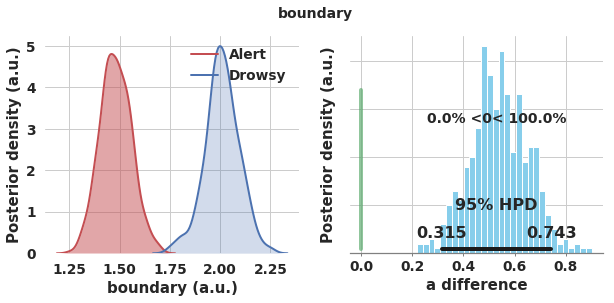

In [35]:
a_Alert, a_Drowsy = m.nodes_db.node[['a(Alert)', 'a(Drowsy)']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axplot_1 = sns.kdeplot(a_Alert.trace(), shade = True, vertical=False, label = "Alert",color = "r",linewidth = 2, ax=ax[0])   
axplot_1.collections[0].set_alpha(0.5)
axplot_2 = sns.kdeplot(a_Drowsy.trace(), shade = True, vertical=False, label = "Drowsy", color = "b",linewidth = 2,ax=ax[0])
axplot_2.collections[0].set_alpha(0.5)
axplot_3 = ax[0].legend(['Alert','Drowsy'],loc='upper right',framealpha = 0)
ax[0].set(xlabel='boundary (a.u.)', ylabel='Posterior density (a.u.)')
effect_size = effectsize(a_Alert, a_Drowsy)
trace = a_Drowsy.trace() - a_Alert.trace() 
# axplot = pm.plot_posterior(trace, ref_val=0, point_estimate = None, hdi_prob = 0.95, kind='hist',
#                            color='#87ceeb',  ax=ax[1])
pm.plot_posterior(trace, varnames=['diff_of_means','diff_of_stds', 'effect_size'],
                  ref_val=0,point_estimate = False,
                  color='#87ceeb', ax=ax[1])
axplot.set_title("difference", fontsize = 14, fontweight = 'bold')

ax[1].set(xlabel='a difference', ylabel='Posterior density (a.u.)')

axplot_1.set_frame_on(False)
axplot_1.grid(True)
axplot_2.set_frame_on(False)
axplot_2.grid(True)

print('P_a(a_Alert > a_Drowsy) = ', 100*(a_Alert.trace() > a_Drowsy.trace()).mean())
print('Effect size = ', effect_size)
plt.suptitle("boundary", fontsize = 14, weight = 'bold')

('P_z(z_Right > z_Left) = ', 1.5555555555555556)
('Effect size = ', 1.5786901472378272)


Text(0.5,0.98,'Bias point')

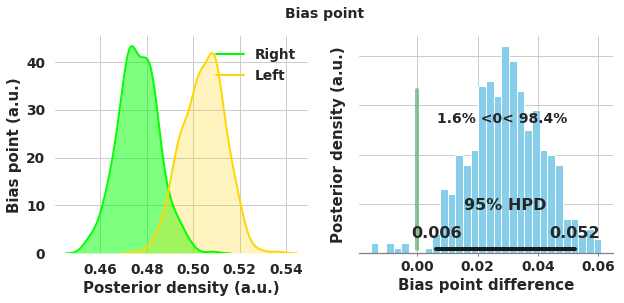

In [36]:
z_Right, z_Left = m.nodes_db.node[['z(Right)', 'z(Left)']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axplot_1 = sns.kdeplot(z_Right.trace(), shade = True, vertical=False, label = "Right",color = "lime",linewidth = 2, ax=ax[0])   
axplot_1.collections[0].set_alpha(0.5)
axplot_2 = sns.kdeplot(z_Left.trace(), shade = True, vertical=False, label = "Left", color = "gold",linewidth = 2,ax=ax[0])
axplot_2.collections[0].set_alpha(0.5)
axplot_3 = ax[0].legend(['Right','Left'],loc='upper right',framealpha = 0)
ax[0].set(ylabel='Bias point (a.u.)', xlabel='Posterior density (a.u.)')
effect_size = effectsize(z_Left, z_Right)
trace = z_Left.trace() - z_Right.trace()
# axplot = pm.plot_posterior(trace, ref_val=0, point_estimate = None, hdi_prob = 0.95, kind='hist',
#                            color='#87ceeb',  ax=ax[1])
pm.plot_posterior(trace, varnames=['diff_of_means','diff_of_stds', 'effect_size'],
                  ref_val=0,point_estimate = False,
                  color='#87ceeb', ax=ax[1])
axplot.set_title("difference", fontsize = 14, fontweight = 'bold')

ax[1].set(xlabel='Bias point difference', ylabel='Posterior density (a.u.)')

axplot_1.set_frame_on(False)
axplot_1.grid(True)
axplot_2.set_frame_on(False)
axplot_2.grid(True)

print('P_z(z_Right > z_Left) = ', 100*(z_Right.trace() > z_Left.trace()).mean())
print('Effect size = ', effect_size)
plt.suptitle("Bias point", fontsize = 14, weight = 'bold')

('P_v(v_Alertleft > v_Alertright) = ', 71.555555555555543)
('Effect size = ', -0.37735266413939206)


Text(0.5,0.98,'Drift rate (Alert)')

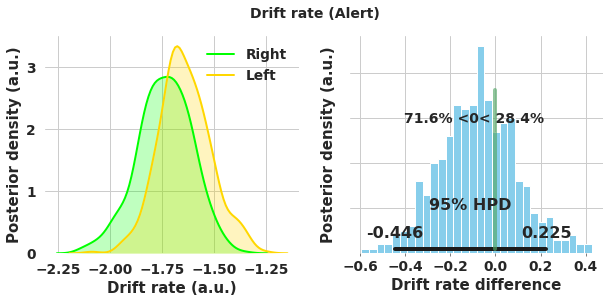

In [37]:
v_Alertright,v_Alertleft = m.nodes_db.node[['v(Alert.Right)','v(Alert.Left)']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.kdeplot(v_Alertright.trace(), shade = True,vertical=False, label = "v_Alertright", color = 'lime',linewidth = 2, ax=ax[0])
sns.kdeplot(v_Alertleft.trace(), shade = True, vertical=False, label = "v_Alertleft", color = 'gold',linewidth = 2, ax=ax[0])
ax[0].legend(['Right','Left'],loc='upper right',framealpha = 0)
ax[0].set(xlabel='Drift rate (a.u.)', ylabel='Posterior density (a.u.)')
effect_size = effectsize(v_Alertright, v_Alertleft)
trace = v_Alertright.trace() - v_Alertleft.trace()
# axplot = pm.plot_posterior(trace, ref_val=0, point_estimate = None, hdi_prob = 0.95, kind='hist',
#                            color='#87ceeb',  ax=ax[1])
pm.plot_posterior(trace, varnames=['diff_of_means','diff_of_stds', 'effect_size'],
                  ref_val=0,point_estimate = False,
                  color='#87ceeb', ax=ax[1])
axplot.set_title("difference", fontsize = 14, fontweight = 'bold')

ax[1].set(xlabel='Drift rate difference', ylabel='Posterior density (a.u.)')

ax[0].set_frame_on(False)
ax[0].grid(True)
ax[1].set_frame_on(False)
ax[1].grid(True)

print('P_v(v_Alertleft > v_Alertright) = ', 100*(v_Alertleft.trace() > v_Alertright.trace()).mean())
print('Effect size = ', effect_size)
plt.suptitle("Drift rate (Alert)", fontsize = 14, weight = 'bold')

('P_v(v_Drowsyleft > v_Drowsyright) = ', 99.555555555555557)
('Effect size = ', -2.0156789744314345)


Text(0.5,0.98,'Drift rate (Drowsy)')

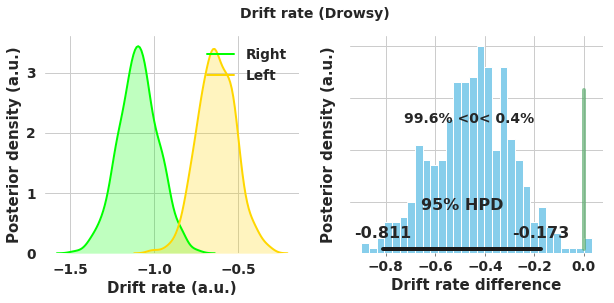

In [38]:
v_Drowsyright,v_Drowsyleft = m.nodes_db.node[['v(Drowsy.Right)','v(Drowsy.Left)']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.kdeplot(v_Drowsyright.trace(), shade = True, vertical=False, label = "v_Drowsyright", color = 'lime',linewidth = 2, ax=ax[0])
sns.kdeplot(v_Drowsyleft.trace(), shade = True, vertical=False, label = "v_Drowsyleft", color = 'gold',linewidth = 2, ax=ax[0])
ax[0].legend(['Right','Left'],loc='upper right',framealpha = 0)
ax[0].set(xlabel='Drift rate (a.u.)', ylabel='Posterior density (a.u.)')

effect_size = effectsize(v_Drowsyright, v_Drowsyleft)
trace = v_Drowsyright.trace() - v_Drowsyleft.trace()
# axplot = pm.plot_posterior(trace, ref_val=0, point_estimate = None, hdi_prob = 0.95, kind='hist',
#                            color='#87ceeb',  ax=ax[1])
pm.plot_posterior(trace, varnames=['diff_of_means','diff_of_stds', 'effect_size'],
                  ref_val=0,point_estimate = False,
                  color='#87ceeb', ax=ax[1])
axplot.set_title("difference", fontsize = 14, fontweight = 'bold')

ax[1].set(xlabel='Drift rate difference', ylabel='Posterior density (a.u.)')

ax[0].set_frame_on(False)
ax[0].grid(True)
ax[1].set_frame_on(False)
ax[1].grid(True)

print('P_v(v_Drowsyleft > v_Drowsyright) = ', 100*(v_Drowsyleft.trace() > v_Drowsyright.trace()).mean())
print('Effect size = ', effect_size)
plt.suptitle("Drift rate (Drowsy)", fontsize = 14, weight = 'bold')

In [39]:
# Load all modules..
from scipy.io import loadmat
from copy import deepcopy
from scipy import stats

In [40]:
# Load all mne modules..
import mne
from mne import io, read_epochs, Epochs, read_evokeds, combine_evoked
from mne.preprocessing import ICA
from mne.decoding import (Vectorizer, SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)
from mne.stats import ttest_1samp_no_p
from mne.stats import (spatio_temporal_cluster_1samp_test,
                       permutation_cluster_1samp_test)

In [41]:
print('mne version: ' + mne.__version__)

mne version: 0.17.0


In [42]:
def regressionplot(scores_cond, p_values_cond, times, alpha=5, color = 'r'):
    scores = np.array(scores_cond)
    sig= p_values_cond < alpha
    
    scores_m = np.nanmean(scores, axis=0)
    sem = 0
    fig, ax = plt.subplots(1, 1, figsize=[12, 3])
    ax.plot(times, scores_m, 'k',linewidth=1,)
    ax.fill_between(times, scores_m-sem, scores_m+sem, color=color, alpha=0.3)
    
    split_ydata = scores_m
    split_ydata[~sig] = np.nan
     
    #shade the significant regions..
    ax.plot(times, split_ydata,color='k', linewidth=3)
    ax.fill_between(times, y1=split_ydata, y2=0.5, alpha=0.7, facecolor=color)
          
    ax.axhline(y=0.5, linewidth=0.75, color='k',linestyle = '--')
    ax.axvline(x=0, linewidth=0.75, color='k',linestyle = '--')
    
    ax.set_xticks([-0.2,-0.1, 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]) 
    ax.axes.xaxis.set_ticklabels(['-0.2','-0.1', '0', '0.1', '0.2','0.3', '0.4','0.5', '0.6','0.7','0.8'])
    
    class Scratch(object):
        pass

    returnval = Scratch()
    
    returnval.axes = ax
    returnval.times = times[sig]
    returnval.scores = scores_m[sig]
    
    return returnval

In [43]:
def _loadbraindata(subj_id):
    # Return eeg data per subject, per channel, per timepoint..
    
    subject_setfile = inputfolder + "s_" + subj_id + "_awake_drowsy_merged_800ms_posttrl_epochs.set"
    
    
    epochs = io.read_epochs_eeglab(subject_setfile, events=None, event_id=None, eog=(),\
                                verbose=None, uint16_codec=None)
    
    #epochs = epochs.resample(100, npad='auto')
    
    subject_matfile = inputfolder + "s_" + subj_id +"_trialstruc.mat"
        
    mat = loadmat(subject_matfile,squeeze_me=True)
    
    # Rearrange Stimstruct and select indices for dropping zero angle trials..
    stimstruct = deepcopy(mat['Stimstruct'])
    stimstruct = np.array([s.encode() for s in stimstruct])
    stimstruct = stimstruct.astype('U13') #converting to unicode..
    
    stimangle = deepcopy(mat['Stimangle'])
        
    ovtrlnums = deepcopy(mat['Ovtrlnums'])
    
    event_zeAC = np.array(stimstruct == 'zeAC')
    event_zeAI = np.array(stimstruct == 'zeAI')
    event_zeAN = np.array(stimstruct == 'zeAN')
    
    event_zeDC = np.array(stimstruct == 'zeDC')
    event_zeDI = np.array(stimstruct == 'zeDI')
    event_zeDN = np.array(stimstruct == 'zeDN')
    
    event_zeRC = np.array(stimstruct == 'zeRC')
    event_zeRI = np.array(stimstruct == 'zeRI')
    event_zeRN = np.array(stimstruct == 'zeRN')
    
    
    event_sel = ~np.array(event_zeAC | event_zeAI | event_zeAN | +
                          event_zeDC | event_zeDI | event_zeDN | +
                          event_zeRC | event_zeRI | event_zeRN)
    
    # Remove the zero stim trials in all conditions..
    epoch_clean = epochs[event_sel]
    stimstruct_clean = stimstruct[event_sel]
    stimangle_clean = stimangle[event_sel]
    ovtrlnums_clean = ovtrlnums[event_sel]
    
    X = epoch_clean
    x_data = X.get_data()
    chan_names = X.info['ch_names']
    #time_indexes = X.times
    time_indexes = numpy.arange(-0.175, 0.800, 0.05)
    
    #cut the data from 175 ms to 625 ms to speed up..
    #x_data = x_data[:,:,((time_indexes >= 0.175) & (time_indexes <= 0.625))]
    #time_indexes = time_indexes[(time_indexes >= 0.175) & (time_indexes <= 0.625)]
        
    class Scratch(object):
        pass

    returnval = Scratch()
    
    returnval.braindata = (10**6) * x_data #scale erp data as it is by default imported in uV
    returnval.chan_names = chan_names
    returnval.time_indexes = time_indexes
    returnval.ovtrialnums = ovtrlnums_clean
    returnval.subj_id = int(subj_id)
    
    return returnval

In [44]:
chance = .5
alpha = 0.05

#adapted from https://github.com/kingjr/decod_unseen_maintenance/blob/master/scripts/base.py
#performs stats of the group level..
#X is usually nsubj x ntpts -> composed of mean roc scores per subj per timepoint..
#performs cluster stats on X to identify regions of tpts that have roc significantly 
#differ from chance..

def _stats(X, connectivity=None, n_jobs=-1):
    """Cluster statistics to control for multiple comparisons.
    Parameters
    ----------
    X : array, shape (n_samples, n_space, n_times)
        The data, chance is assumed to be 0.
    connectivity : None | array, shape (n_space, n_times)
        The connectivity matrix to apply cluster correction. If None uses
        neighboring cells of X.
    n_jobs : int
        The number of parallel processors.
    """
    n_subjects = len(X)
    X = np.array(X)
    X = X[:, :, None] if X.ndim == 2 else X
    #this functions gets the t-values and performs a cluster permutation test on them to determine
    #p-values..
    p_threshold = 0.05
    t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects - 1)
    T_obs_, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(
        X, out_type='mask', stat_fun=_stat_fun, n_permutations=2**12,
        n_jobs=n_jobs, connectivity=connectivity,threshold=t_threshold)
    p_values_ = np.ones_like(X[0]).T
    #rearrange the p-value per cluster..
    for cluster, pval in zip(clusters, p_values):
        p_values_[cluster.T] = pval
    return np.squeeze(p_values_).T

def _stat_fun(x, sigma=0, method='relative'):
    """This secondary function reduces the time of computation of p-values and adjusts for small-variance
       values
    """
    t_values = ttest_1samp_no_p(x, sigma=sigma, method=method)
    t_values[np.isnan(t_values)] = 0
    return t_values

In [45]:
inputfolder = base_dir + "decAlertnessDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/"
outputfolder = base_dir + "decAlertnessDecisionmaking_JNeuroscience2021/Results/results_hddmRegression/"

In [46]:
subjects = ['02','04','05','06','07','09','10','20','21','22',\
            '23','24','25','26','27','28','30','31','32','33',\
            '34','35','36','37','38','39','41','42','43','44',\
            '45','46']

In [47]:
#load braindata (eeg per subject)
brainstructdata = []
matchederpdatastruct = []
matchedbehdatastruct = []
for s, subject in enumerate(subjects):  # Loop across each subject
    print(subject)
    brainstructdata.append(_loadbraindata(subject))
    
    print('Subject:' , str(brainstructdata[s].subj_id))
    print('ERP data size:' , str(np.shape(brainstructdata[s].braindata)))
    print('Chan size:' , str(np.shape(brainstructdata[s].chan_names)))
    print('Overall trials#:' , str(np.shape(brainstructdata[s].ovtrialnums)))
    
    #now match behavioral and braindata trial numbers per subject
    eegtrialnums = brainstructdata[s].ovtrialnums
    behtrialnums = behdata.ovtrlnums[behdata['subj_idx'] == brainstructdata[s].subj_id]
    eegtrialmask = np.isin(eegtrialnums, behtrialnums)
    behtrialmask = np.isin(behtrialnums, eegtrialnums)
    
    print('EEG trials#:',str(np.sum(eegtrialmask)))
    print('Beh trials#:',str(np.sum(behtrialmask)))
    
    #compute matched trial numbers
    matchedbraintrialnums = brainstructdata[s].ovtrialnums[eegtrialmask]
    matchedbehtrialnums = behdata.ovtrlnums[behdata['subj_idx'] == brainstructdata[s].subj_id][behtrialmask]
    
    matchval = matchedbraintrialnums == matchedbehtrialnums
    if np.sum(matchval) != np.sum(eegtrialmask):
        raise ValueError('Trial mismatch..')
    else:
        print('Trial match..')
    
    #takeout the matched erp data..
    matchedbraindata = brainstructdata[s].braindata[eegtrialmask,:,:]
    print('Matched ERP data size:', str(np.shape(matchedbraindata)))
    
    #takeout the matched beh data..
    matchedbehdata = behdata[behdata['subj_idx'] == brainstructdata[s].subj_id]
    matchedbehdata = matchedbehdata[behtrialmask]
    print('Matched beh data lenght:', str(len(matchedbehdata)))
    
    #now append the list..
    matchederpdatastruct.append(matchedbraindata)
    matchedbehdatastruct.append(matchedbehdata)

02
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/s_02_awake_drowsy_merged_800ms_posttrl_epochs.set...
615 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
('Subject:', '2')
('ERP data size:', '(599, 92, 20)')
('Chan size:', '(92,)')
('Overall trials#:', '(599,)')
('EEG trials#:', '414')
('Beh trials#:', '414')
Trial match..
('Matched ERP data size:', '(414, 92, 20)')
('Matched beh data lenght:', '414')
04
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/s_04_awake_drowsy_merged_800ms_posttrl_epochs.set...
803 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
('Subject:', '4')
('ERP data size:', '(781, 92, 2

Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/s_27_awake_drowsy_merged_800ms_posttrl_epochs.set...
743 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
('Subject:', '27')
('ERP data size:', '(722, 92, 20)')
('Chan size:', '(92,)')
('Overall trials#:', '(722,)')
('EEG trials#:', '124')
('Beh trials#:', '124')
Trial match..
('Matched ERP data size:', '(124, 92, 20)')
('Matched beh data lenght:', '124')
28
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/s_28_awake_drowsy_merged_800ms_posttrl_epochs.set...
805 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
('Subject:', '28')
('ERP data size:', '(781, 92, 20

('Matched beh data lenght:', '705')
43
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/s_43_awake_drowsy_merged_800ms_posttrl_epochs.set...
766 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
('Subject:', '43')
('ERP data size:', '(744, 92, 20)')
('Chan size:', '(92,)')
('Overall trials#:', '(744,)')
('EEG trials#:', '491')
('Beh trials#:', '491')
Trial match..
('Matched ERP data size:', '(491, 92, 20)')
('Matched beh data lenght:', '491')
44
Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/s_44_awake_drowsy_merged_800ms_posttrl_epochs.set...
841 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
('Subject:',

In [48]:
for s, subject in enumerate(subjects):  # Loop across each subject
    print(subject)
    print('summary erp data length:',str(np.shape(matchederpdatastruct[s])))
    print('summary beh data length:',str(len(matchedbehdatastruct[s])))

02
('summary erp data length:', '(414, 92, 20)')
('summary beh data length:', '414')
04
('summary erp data length:', '(642, 92, 20)')
('summary beh data length:', '642')
05
('summary erp data length:', '(694, 92, 20)')
('summary beh data length:', '694')
06
('summary erp data length:', '(535, 92, 20)')
('summary beh data length:', '535')
07
('summary erp data length:', '(575, 92, 20)')
('summary beh data length:', '575')
09
('summary erp data length:', '(309, 92, 20)')
('summary beh data length:', '309')
10
('summary erp data length:', '(412, 92, 20)')
('summary beh data length:', '412')
20
('summary erp data length:', '(438, 92, 20)')
('summary beh data length:', '438')
21
('summary erp data length:', '(489, 92, 20)')
('summary beh data length:', '489')
22
('summary erp data length:', '(180, 92, 20)')
('summary beh data length:', '180')
23
('summary erp data length:', '(662, 92, 20)')
('summary beh data length:', '662')
24
('summary erp data length:', '(423, 92, 20)')
('summary beh da

In [49]:
brainstructdata[0].time_indexes

array([-0.175, -0.125, -0.075, -0.025,  0.025,  0.075,  0.125,  0.175,
        0.225,  0.275,  0.325,  0.375,  0.425,  0.475,  0.525,  0.575,
        0.625,  0.675,  0.725,  0.775])

In [50]:
len(brainstructdata[0].time_indexes)

20

In [51]:
len(brainstructdata[0].chan_names)

92

In [52]:
sample_setfile = inputfolder + "s_02" + "_awake_drowsy_merged_800ms_posttrl_epochs.set"
sample_epochs = io.read_epochs_eeglab(sample_setfile, events=None, event_id=None, eog=(),\
                                verbose=None, uint16_codec=None)

Extracting parameters from /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Preprocessed/post_trial/13_zscored/s_02_awake_drowsy_merged_800ms_posttrl_epochs.set...
615 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


In [53]:
def multi_run_hddmreg(args):
    tempargs = args
    reg_behdata = tempargs[0]
    elidx = tempargs[1]
    tidx = tempargs[2]
    
    #print('\n\n elec idx is: ', elidx,'--- tidx idx is: ', tidx, ' \n')

    model_desc = "v ~ erpval:C(state, Treatment('Alert')):C(stim, Treatment('Right'))"
    #here, the drift rate depends on the erpval and varies with state with 'Alert' as reference level
    #and varies with stim with 'Right' as reference level
    #best model from before
    m_reg = hddm.HDDMRegressor(reg_behdata, model_desc,
                               bias=True,
                               depends_on={'z':'stim', 'a':'state', 't': 'state'},
                               p_outlier = 0.05)

    #m_reg.sample(5, burn=1)#For testing purposes..
    m_reg.sample(100, burn=20)

    #store the results..
    alertleft_str = "v_erpval:C(state, Treatment('Alert'))[Alert]:C(stim, Treatment('Right'))[Left]"
    v_erpAlertleft = m_reg.nodes_db.node[alertleft_str]
    alertright_str = "v_erpval:C(state, Treatment('Alert'))[Alert]:C(stim, Treatment('Right'))[Right]"
    v_erpAlertright = m_reg.nodes_db.node[alertright_str]

    drowyleft_str = "v_erpval:C(state, Treatment('Alert'))[Drowsy]:C(stim, Treatment('Right'))[Left]"
    v_erpDrowsyleft = m_reg.nodes_db.node[drowyleft_str]
    drowsyright_str = "v_erpval:C(state, Treatment('Alert'))[Drowsy]:C(stim, Treatment('Right'))[Right]"
    v_erpDrowsyright = m_reg.nodes_db.node[drowsyright_str]



    v_temperpAlertdiff = 100*(v_erpAlertleft.trace() > v_erpAlertright.trace()).mean()
    v_temperpDrowsydiff = 100*(v_erpDrowsyleft.trace() > v_erpDrowsyright.trace()).mean()
        
    
    col_names =  ['erpAlertdiff', 'erpDrowsydiff', 'elidx', 'tidx']
    data = []
    data.append([v_temperpAlertdiff, v_temperpDrowsydiff, elidx, tidx])
    v_reg  = pd.DataFrame(data, columns = col_names)
 
    #print('v_erpAlertdiff idx is: ', v_reg['erpAlertdiff'])
    #print('v_erpDrowsydiff idx is: ', v_reg['erpDrowsydiff'])
    return v_reg

In [54]:
#commented lines, 193,194 in hddm_regression.py in site-packages/hddm/models
#print("Adding these covariates:")
#print(model_descr['params'])

In [55]:
for s, subject in enumerate(subjects):
    #initalise variables now..
    reg_erpdata = []
    reg_behdata = []
    v_erpAlertdiff = numpy.empty((len(brainstructdata[0].chan_names),len(brainstructdata[0].time_indexes),))
    v_erpDrowsydiff = numpy.empty((len(brainstructdata[0].chan_names),len(brainstructdata[0].time_indexes),))
    v_erpAlertdiff[:] = numpy.nan
    v_erpDrowsydiff[:] = numpy.nan
    
    behlist = []
    elecidlist = []
    timeidlist = []
    
    multi_result = []

    awake_filename = outputfolder + 'patterns/' + subject + '_' + 'awake_patterns_driftrateregression_ave.fif'
    drowsy_filename = outputfolder + 'patterns/' + subject + '_' + 'drowsy_patterns_driftrateregression_ave.fif'
    
    start_time = timeit.default_timer()
    
    if not (os.path.exists(awake_filename) and os.path.exists(drowsy_filename)):
        print ('\n*******Processing subject: ' + str(subject) + '*******')
        for tidx, timeindex in enumerate(brainstructdata[0].time_indexes):#tidx in range(0,1):
            for elidx in range(0,len(brainstructdata[0].chan_names)):#range(0,1)
           
            
                tmperpdata =[]
                tmpbehdata =[]
        
                tmpval = matchederpdatastruct[s]
                #print (np.shape(tmpval))
                tmperpdata.append(tmpval[:,elidx,tidx])
                tmpbehdata.append(matchedbehdatastruct[s])
                #now prepare for regression..
                reg_behdata = pd.concat(tmpbehdata) 
                reg_erpdata = numpy.concatenate(tmperpdata, axis=0)
                reg_behdata['erpval'] = reg_erpdata
        
        
                behlist.append(reg_behdata)
                elecidlist.append(elidx)
                timeidlist.append(tidx)
    
        fullist = [x for x in zip(behlist, elecidlist,timeidlist)]
        #With multiprocessing (can take a lot of time!)
        if __name__ == "__main__":
            #pool = Pool(len(fullist))
            pool = Pool(multiprocessing.cpu_count()-4) 
            multi_result = pool.map(multi_run_hddmreg,fullist)
        
        for m in range(0,len(multi_result)):
            tempdf = multi_result[m]
            elidx = tempdf['elidx'].values[0]
            tidx = tempdf['tidx'].values[0]
        
            v_erpAlertdiff[elidx,tidx] = tempdf['erpAlertdiff'].values[0]
            v_erpDrowsydiff[elidx,tidx] = tempdf['erpDrowsydiff'].values[0]
        
        #save the data now..
        prop_overlap_Alert = v_erpAlertdiff
        prop_overlap_Drowsy = v_erpDrowsydiff
    
        nave = 1 # The number of subjects that created this..
    
        comment = subject + "_Alert"
        # Create the Evoked object
        evoked_Alert = mne.EvokedArray(prop_overlap_Alert, sample_epochs.info, 
                                       tmin = min(brainstructdata[0].time_indexes),comment=comment, nave=nave)
    
        evoked_Alert.save(awake_filename)
            
        comment = subject + "_Drowsy"
        evoked_Drowsy = mne.EvokedArray(prop_overlap_Drowsy, sample_epochs.info, 
                                        tmin = min(brainstructdata[0].time_indexes),comment=comment, nave=nave)
        evoked_Drowsy.save(drowsy_filename)
        
    else:
        print('\n*******Skipping subject: ' + str(subject) + '*******')
        
    # code you want to evaluate
    elapsed = timeit.default_timer() - start_time
    print('\nconsumed time :'+ str(datetime.timedelta(seconds=elapsed)))


*******Skipping subject: 02*******

consumed time :0:00:00.000295

*******Skipping subject: 04*******

consumed time :0:00:00.000382

*******Skipping subject: 05*******

consumed time :0:00:00.000249

*******Skipping subject: 06*******

consumed time :0:00:00.000267

*******Skipping subject: 07*******

consumed time :0:00:00.000300

*******Skipping subject: 09*******

consumed time :0:00:00.000147

*******Skipping subject: 10*******

consumed time :0:00:00.000127

*******Skipping subject: 20*******

consumed time :0:00:00.000177

*******Skipping subject: 21*******

consumed time :0:00:00.000134

*******Skipping subject: 22*******

consumed time :0:00:00.000170

*******Skipping subject: 23*******

consumed time :0:00:00.000247

*******Skipping subject: 24*******

consumed time :0:00:00.000153

*******Skipping subject: 25*******

consumed time :0:00:00.000278

*******Skipping subject: 26*******

consumed time :0:00:00.000149

*******Skipping subject: 27*******

consumed time :0:00:00.00

In [56]:
print('Script ended at: ' +  time.strftime('%X %x %Z'))

Script ended at: 07:59:34 04/04/21 BST


In [57]:
epochs_fnames = list()
for subjidx, subject in enumerate(subjects):  # Loop across each subject
    #print subject
    fnamepath = outputfolder + 'patterns/' + subject + '_' + 'awake_patterns_driftrateregression_ave.fif'
    if os.path.isfile(fnamepath):
        epochs_fnames.append(fnamepath)
    else:
        print "Skipping file"
    
evokeds_alert = [read_evokeds(f, verbose='error')[0] for f in epochs_fnames]
mean_evoked_alert = combine_evoked(evokeds_alert, weights="equal")

In [58]:
len(epochs_fnames)

32

In [59]:
brainstructdata[0].time_indexes

array([-0.175, -0.125, -0.075, -0.025,  0.025,  0.075,  0.125,  0.175,
        0.225,  0.275,  0.325,  0.375,  0.425,  0.475,  0.525,  0.575,
        0.625,  0.675,  0.725,  0.775])

In [60]:
mean_evoked_alert.data = mean_evoked_alert.data/(10**6)
mean_evoked_alert.times = brainstructdata[0].time_indexes

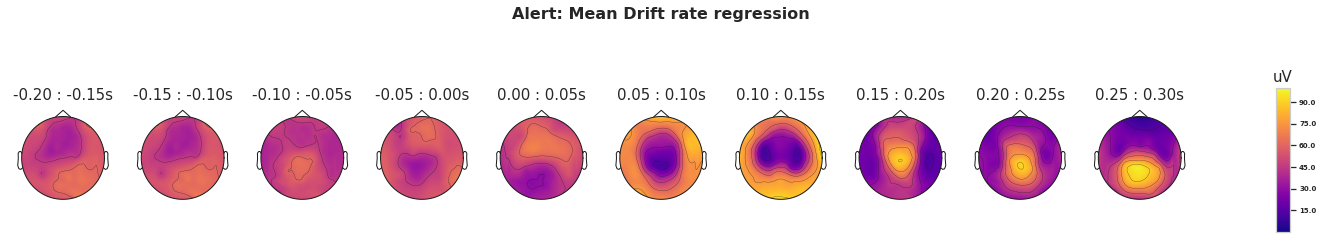

In [61]:
times = [-0.175, -0.125, -0.075, -0.025, 0.025, 
         0.075, 0.125, 0.175, 0.225, 0.275]
#stat annotation
time_format = ['-0.20 : -0.15s', '-0.15 : -0.10s', '-0.10 : -0.05s', '-0.05 : 0.00s','0.00 : 0.05s',\
               '0.05 : 0.10s', '0.10 : 0.15s', '0.15 : 0.20s', '0.20 : 0.25s', '0.25 : 0.30s']

figw, figh = 20, 4
fig, ax = plt.subplots(nrows=1, ncols=len(times)+1, figsize=[figw, 4])

cmin =0
cmax = 100

for idx in range(len(times)):
    kwargs = dict(times=times[idx], time_format = time_format[idx],cmap = 'plasma',time_unit='ms', show=False,
              contours=6, sensors=False, vmin = cmin, vmax = cmax)
    if idx < len(times)-1:
        mean_evoked_alert.plot_topomap(axes = ax[idx],colorbar=False,**kwargs)
    else:
        mean_evoked_alert.plot_topomap(axes = ax[idx],colorbar=True,**kwargs)

fig.suptitle('Alert: Mean Drift rate regression',fontsize = 16, fontweight = 'heavy')
plt.show()

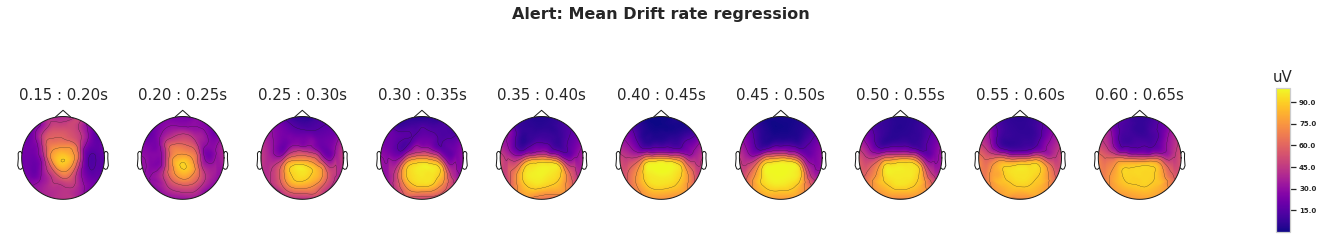

In [62]:
times = [0.175, 0.225, 0.275, 0.325, 0.375, 
         0.425, 0.475, 0.525, 0.575, 0.625]
#stat annotation
time_format = ['0.15 : 0.20s', '0.20 : 0.25s', '0.25 : 0.30s', '0.30 : 0.35s','0.35 : 0.40s',\
               '0.40 : 0.45s', '0.45 : 0.50s', '0.50 : 0.55s', '0.55 : 0.60s', '0.60 : 0.65s']

figw, figh = 20, 4
fig, ax = plt.subplots(nrows=1, ncols=len(times)+1, figsize=[figw, 4])

cmin =0
cmax = 100

for idx in range(len(times)):
    kwargs = dict(times=times[idx], time_format = time_format[idx],cmap = 'plasma',time_unit='ms', show=False,
              contours=6, sensors=False, vmin = cmin, vmax = cmax)
    if idx < len(times)-1:
        mean_evoked_alert.plot_topomap(axes = ax[idx],colorbar=False,**kwargs)
    else:
        mean_evoked_alert.plot_topomap(axes = ax[idx],colorbar=True,**kwargs)

fig.suptitle('Alert: Mean Drift rate regression',fontsize = 16, fontweight = 'heavy')
plt.show()

In [63]:
epochs_fnames = list()
for subjidx, subject in enumerate(subjects):  # Loop across each subject
    fnamepath = outputfolder + 'patterns/' + subject + '_' + 'drowsy_patterns_driftrateregression_ave.fif'
    if os.path.isfile(fnamepath):
        epochs_fnames.append(fnamepath)
    else:
        print "Skipping file"
    
evokeds_drowsy = [read_evokeds(f, verbose='error')[0] for f in epochs_fnames]
mean_evoked_drowsy = combine_evoked(evokeds_drowsy, weights="equal")

In [64]:
len(epochs_fnames)

32

In [65]:
mean_evoked_drowsy.data = mean_evoked_drowsy.data/(10**6)
mean_evoked_drowsy.times = brainstructdata[0].time_indexes

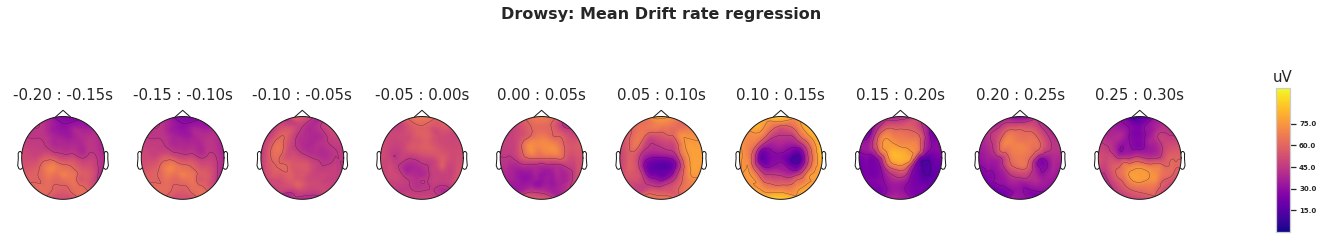

In [66]:
times = [-0.175, -0.125, -0.075, -0.025, 0.025, 
         0.075, 0.125, 0.175, 0.225, 0.275]
#stat annotation
time_format = ['-0.20 : -0.15s', '-0.15 : -0.10s', '-0.10 : -0.05s', '-0.05 : 0.00s','0.00 : 0.05s',\
               '0.05 : 0.10s', '0.10 : 0.15s', '0.15 : 0.20s', '0.20 : 0.25s', '0.25 : 0.30s']

figw, figh = 20, 4
fig, ax = plt.subplots(nrows=1, ncols=len(times)+1, figsize=[figw, 4])

cmin =0
cmax = 100

for idx in range(len(times)):
    kwargs = dict(times=times[idx], time_format = time_format[idx],cmap = 'plasma',time_unit='ms', show=False,
              contours=6, sensors=False, vmin = cmin, vmax = cmax)
    if idx < len(times)-1:
        mean_evoked_drowsy.plot_topomap(axes = ax[idx],colorbar=False,**kwargs)
    else:
        mean_evoked_drowsy.plot_topomap(axes = ax[idx],colorbar=True,**kwargs)

fig.suptitle('Drowsy: Mean Drift rate regression',fontsize = 16, fontweight = 'heavy')
plt.show()

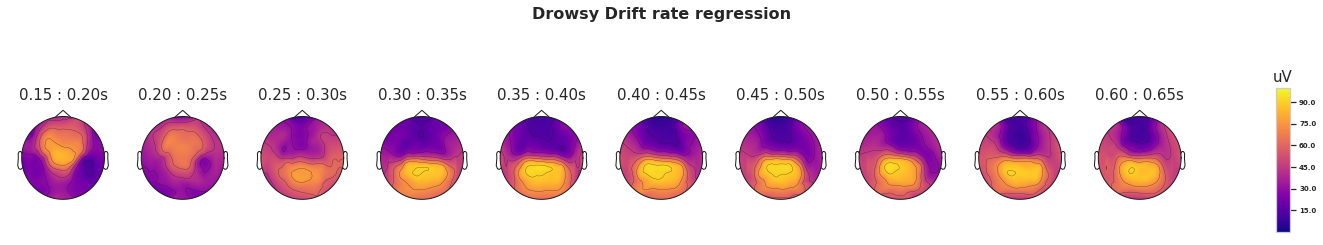

In [67]:
times = [0.175, 0.225, 0.275, 0.325, 0.375, 
         0.425, 0.475, 0.525, 0.575, 0.625]
#stat annotation
time_format = ['0.15 : 0.20s', '0.20 : 0.25s', '0.25 : 0.30s', '0.30 : 0.35s','0.35 : 0.40s',\
               '0.40 : 0.45s', '0.45 : 0.50s', '0.50 : 0.55s', '0.55 : 0.60s', '0.60 : 0.65s']

fig, ax = plt.subplots(nrows=1, ncols=len(times)+1, figsize=[20., 4])

cmin =0
cmax = 100

for idx in range(len(times)):
    kwargs = dict(times=times[idx], time_format = time_format[idx],cmap = 'plasma',time_unit='ms', show=False,
              contours=6, sensors=False, vmin = cmin, vmax = cmax)
    if idx < len(times)-1:
        mean_evoked_drowsy.plot_topomap(axes = ax[idx],colorbar=False,**kwargs)
    else:
        mean_evoked_drowsy.plot_topomap(axes = ax[idx],colorbar=True,**kwargs)

fig.suptitle('Drowsy Drift rate regression',fontsize = 16, fontweight = 'heavy')
plt.show()